## IOU & NMS

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#### BBox

In [7]:
class Bounding_box:
    def __init__(self, x1, y1, x2, y2, score):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.score = score

In [8]:
box1 = Bounding_box(13, 22, 268, 367, 0.124648176)
box2 = Bounding_box(18, 27, 294, 400, 0.35818103)
box3 = Bounding_box(234, 123, 466, 678, 0.13638769)
box_lists = [box1, box2, box3]

In [9]:
def show_bbox(image, box_lists):
    for i, bbox in enumerate(box_lists):
        draw_bbox(image, bbox, f'bbox{i+1}')
    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()
    
    
def draw_bbox(image, bbox, text):
    cv2.rectangle(image, pt1=(bbox.x1,bbox.y1), #通过bbox.left()得到4个点坐标
                 pt2=(bbox.x2,bbox.y2), 
                 color=(0,0,225), thickness=2) #RGB
    cv2.putText(image, text=text,
                org=(bbox.x1-5,bbox.y1-5), #框左上角坐标为文字的左下角
                fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1, #字体，大小
                color=(0,0,225), thickness=2, lineType=cv2.LINE_AA) #文字颜色，线条粗细

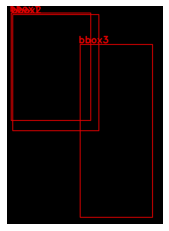

In [10]:
image = np.zeros([700,500,3], dtype='uint8')
show_bbox(image, box_lists)

#### IOU & Dice

In [11]:
def get_iou(boxa, boxb):
    max_x = max(boxa.x1, boxb.x1)
    max_y = max(boxa.y1, boxb.y1)
    min_x = min(boxa.x2, boxb.x2)
    min_y = min(boxa.y2, boxb.y2)
    if min_x <= max_x or min_y <= max_y: #没有交集
        return 0
    area_i = (min_x - max_x) * (min_y - max_y)
    area_a = (boxa.x2 - boxa.x1) * (boxa.y2 - boxa.y1)
    area_b = (boxb.x2 - boxb.x1) * (boxb.y2 - boxb.y1)
    area_u = area_a + area_b - area_i
    return float(area_i) / float(area_u)

def get_dice(boxa, boxb):
    max_x = max(boxa.x1, boxb.x1)
    max_y = max(boxa.y1, boxb.y1)
    min_x = min(boxa.x2, boxb.x2)
    min_y = min(boxa.y2, boxb.y2)
    if min_x <= max_x or min_y <= max_y: #没有交集
        return 0
    area_i = (min_x - max_x) * (min_y - max_y)
    area_a = (boxa.x2 - boxa.x1) * (boxa.y2 - boxa.y1)
    area_b = (boxb.x2 - boxb.x1) * (boxb.y2 - boxb.y1)
    return 2*float(area_i) / (float(area_a)+float(area_b))

In [12]:
get_iou(box1, box2)
get_dice(box1, box2)

0.8024697185691493

0.8904113176516187

#### NMS

In [13]:
# 先筛选confidence>0.6的bbox
# 然后按照score = confidence*P(k)得到每个bbox最高概率类别的score
# 按类别，从最高score的bbox开始遍历
def NMS(box_lists, k): #最终保留k个bbox
    box_lists = sorted(box_lists, key=lambda x: x.score, reverse=True)
    NMS_lists = [box_lists[0]] #首先保留最高分
    temp_lists = []
    for i in range(k): #遍历最高分bbox
        for j in range(1, len(box_lists)): #遍历候补bbox
            iou = get_iou(NMS_lists[i], box_lists[j])
            if iou < 0.7: #把重叠iou>=0.7的都从候补去掉
                temp_lists.append(box_lists[j])
        if len(temp_lists) == 0: #已经分配完毕
            return NMS_lists
        box_lists = temp_lists #更新后补bbox
        temp_lists = []
        if i<k-1: #如果还有剩下bbox没有分配完，但是已经满了k个，就不需要再加了
            NMS_lists.append(box_lists[0]) #遍历下一个最高分
    return NMS_lists

In [14]:
NMS_list = NMS(box_lists, 2)
for bbox in NMS_list:
    bbox.score

0.35818103

0.13638769